**Transfer learning** is leveraging a working model's existing architecture and tune it for our use case.



In [1]:
from helper_fun import *
import tensorflow_hub as hub

Using tensorflow version: 2.4.1


### 1. Download and become one with the data

[10_food_classes_10_percent](https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip)

In [2]:
# Run this while working google colab

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

import zipfile

zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2021-05-23 16:47:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 74.125.137.128, 2607:f8b0:4023:c03::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   214MB/s    in 0.7s    

2021-05-23 16:47:16 (214 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
data_dir = pathlib.Path('/content/10_food_classes_10_percent/train')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

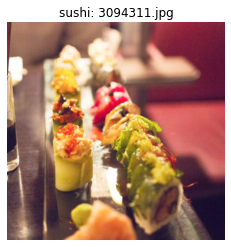

Image shape: (512, 512, 3)


In [4]:
view_random_image('/content/10_food_classes_10_percent/train')

### 2. Creating data loader

In [5]:
IMAGE_SHAPE = (244, 244)
BATCH_SIZE = 32

train_dir = '/content/10_food_classes_10_percent/train'
test_dir = '/content/10_food_classes_10_percent/test'

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_data = train_datagen.flow_from_directory(train_dir, 
                                               target_size= IMAGE_SHAPE,
                                               batch_size= BATCH_SIZE, 
                                               class_mode= 'categorical',
                                               seed = 42)


test_data = test_datagen.flow_from_directory(test_dir, 
                                               target_size= IMAGE_SHAPE,
                                               batch_size= BATCH_SIZE, 
                                               class_mode= 'categorical',
                                               seed = 42)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### 3. Setting up [callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks)

Callbacks are extra functionality that can be added to the model while training.

Common callbacks:
1. Tensorboard callback
2. Model checkpoint
3. Early stopping

In [6]:
# Setup tensorboard callback

import datetime

def create_tensorboard_callback(dir_name, experiment_name):

    log_dir = os.path.join(dir_name, experiment_name, datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= log_dir)
    print(f'Saving tensorboard log files to {log_dir}')
    return tensorboard_callback

### 4. Create model using [Tensorflow Hub](https://tfhub.dev/)

We will try and implement [EfficientNet](https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1) and [ResNet](https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5) model from tensorflow

In [9]:
# We are going to create model with url from tensorflow hub

def create_model(model_url, num_classes = 10):
    """
    Takes a url from tensorflow hub and creates a Keras sequential model with it
    Args:
        1. model_url(str): url from tensorflow hub
        2. num_classes(int): number of output classes
    
    Returns:
        An uncompiled Keras Sequential model with model_url as feature extractor
        layer and a Dense output layer with num_classes units 
    """
    # Download pretrained model
    feature_extractor_layer =  hub.KerasLayer(model_url,
                                              trainable = False,
                                              name = 'feature_extractor_layer',
                                              input_shape = IMAGE_SHAPE + (3,))

    # Create the model
    model = Sequential([
                        feature_extractor_layer,
                        Dense(num_classes, activation = 'softmax', name = 'output_layer')
    ])

    return model

In [10]:
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
effnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

### Create ResNet net model

In [22]:
resnet_model = create_model(resnet_url, num_classes= train_data.num_classes)

# Compile the model
resnet_model.compile(loss= CategoricalCrossentropy(),
                     optimizer = Adam(),
                     metrics = ['accuracy'])

# Create tensorboard callback
resnet_tb_cbk = create_tensorboard_callback('logs', 'resnet')

history_resnet = resnet_model.fit(train_data,
                                  epochs= 5,
                                  steps_per_epoch= len(train_data),
                                  validation_data= test_data,
                                  validation_steps= len(test_data),
                                  callbacks = [resnet_tb_cbk])

Saving tensorboard log files to logs/resnet/20210523_170658
Epoch 1/5
24/24 [==============================] - 55s 815ms/step - loss: 2.2155 - accuracy: 0.2364 - val_loss: 1.1979 - val_accuracy: 0.6416
Epoch 2/5
24/24 [==============================] - 16s 686ms/step - loss: 0.9946 - accuracy: 0.7172 - val_loss: 0.8285 - val_accuracy: 0.7500
Epoch 3/5
24/24 [==============================] - 16s 691ms/step - loss: 0.6850 - accuracy: 0.8065 - val_loss: 0.7400 - val_accuracy: 0.7700
Epoch 4/5
24/24 [==============================] - 16s 692ms/step - loss: 0.4854 - accuracy: 0.8826 - val_loss: 0.6651 - val_accuracy: 0.7940
Epoch 5/5
24/24 [==============================] - 16s 688ms/step - loss: 0.3765 - accuracy: 0.9216 - val_loss: 0.6429 - val_accuracy: 0.7928


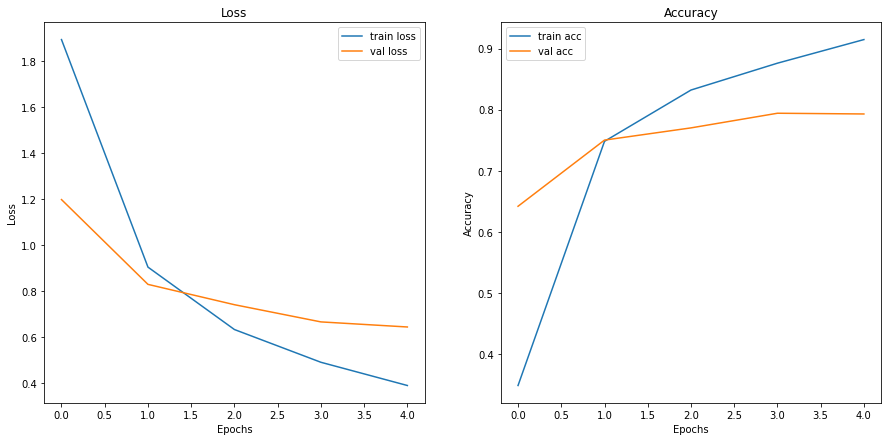

In [23]:
plot_history(history_resnet)

### Create efficient net model

In [24]:
effnet_model = create_model(effnet_url, train_data.num_classes)

effnet_model.compile(loss = CategoricalCrossentropy(),
                     optimizer = Adam(),
                     metrics = ['accuracy'])

effnet_tb_cbk = create_tensorboard_callback('logs', 'effnet')

history_effnet = effnet_model.fit(train_data, 
                                  epochs = 5, 
                                  steps_per_epoch = len(train_data),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  callbacks = [effnet_tb_cbk])

Saving tensorboard log files to logs/effnet/20210523_171631
Epoch 1/5
24/24 [==============================] - 26s 803ms/step - loss: 2.0796 - accuracy: 0.2851 - val_loss: 1.3075 - val_accuracy: 0.7240
Epoch 2/5
24/24 [==============================] - 15s 662ms/step - loss: 1.1475 - accuracy: 0.7995 - val_loss: 0.8747 - val_accuracy: 0.8068
Epoch 3/5
24/24 [==============================] - 15s 652ms/step - loss: 0.7897 - accuracy: 0.8354 - val_loss: 0.7049 - val_accuracy: 0.8400
Epoch 4/5
24/24 [==============================] - 15s 644ms/step - loss: 0.6619 - accuracy: 0.8566 - val_loss: 0.6136 - val_accuracy: 0.8552
Epoch 5/5
24/24 [==============================] - 15s 644ms/step - loss: 0.5456 - accuracy: 0.8761 - val_loss: 0.5588 - val_accuracy: 0.8620


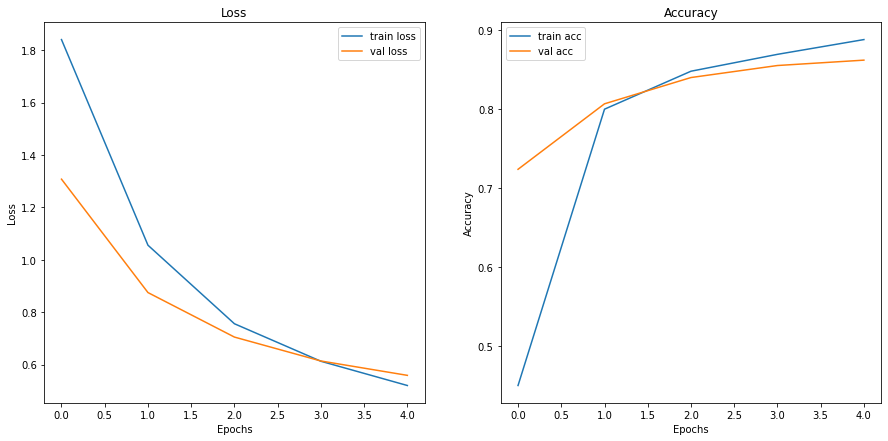

In [25]:
plot_history(history_effnet)

In [30]:
effnet_model.layers[0].weights[0]

<tf.Variable 'stem_conv2d/kernel:0' shape=(3, 3, 3, 32) dtype=float32, numpy=
array([[[[ 2.07668245e-02,  8.53624821e-01, -9.72171009e-01,
           5.80005467e-01,  3.13335508e-02, -1.81043148e-02,
          -1.28635168e-02,  5.94060645e-02, -7.41896749e-01,
          -2.27897346e-01,  2.00766921e-01, -2.33019665e-02,
          -3.82314444e-01, -1.13366711e+00, -4.97356057e-02,
          -5.28575480e-01,  6.01686649e-02,  3.28413874e-01,
           7.26403654e-01,  9.56093222e-02,  2.53003836e-03,
           7.99428642e-01,  1.60467178e-01,  1.51992925e-02,
           2.15564728e-01, -6.15406692e-01,  7.56446272e-02,
           3.47692966e-02,  0.00000000e+00, -6.27994761e-02,
           2.23197415e-02, -1.42137900e-01],
         [ 1.28902495e-02,  1.56575632e+00, -1.80467033e+00,
           7.77730107e-01,  6.52952865e-02,  2.08790317e-01,
          -8.81190374e-02, -3.78276139e-01,  5.80090940e-01,
          -3.44047934e-01,  6.91463649e-02, -8.79267603e-02,
          -4.79018658e-

### Comparing our models with Tensorboard

In [31]:
!zip -r logs.zip logs/

  adding: logs/ (stored 0%)
  adding: logs/effnet/ (stored 0%)
  adding: logs/effnet/20210523_171631/ (stored 0%)
  adding: logs/effnet/20210523_171631/validation/ (stored 0%)
  adding: logs/effnet/20210523_171631/validation/events.out.tfevents.1621790205.df0055288fb8.59.70522.v2 (deflated 49%)
  adding: logs/effnet/20210523_171631/train/ (stored 0%)
  adding: logs/effnet/20210523_171631/train/events.out.tfevents.1621790192.df0055288fb8.59.54586.v2 (deflated 93%)
  adding: logs/effnet/20210523_171631/train/events.out.tfevents.1621790201.df0055288fb8.profile-empty (deflated 5%)
  adding: logs/effnet/20210523_171631/train/plugins/ (stored 0%)
  adding: logs/effnet/20210523_171631/train/plugins/profile/ (stored 0%)
  adding: logs/effnet/20210523_171631/train/plugins/profile/2021_05_23_17_16_41/ (stored 0%)
  adding: logs/effnet/20210523_171631/train/plugins/profile/2021_05_23_17_16_41/df0055288fb8.xplane.pb (deflated 85%)
  adding: logs/effnet/20210523_171631/train/plugins/profile/2021_05

In [32]:
# run this command to visualiza using tensorboard from command prompt

# tensorboard --logir=path/to/log_file